In [3]:
import numpy as np
import math
from scipy import stats

# initialize
numdir = 8              # dir groups by increments of 45
numTC  = 30             # 240 total TC cells, 8 direction groups 30 cells each
numRS  = 20             # 160 total RS cells, 8 direction groups 20 cells each
numFS  = 100            # 100 FS cells no direction selectivity 
tRS = numdir * numRS          # total RS cells
tTC = numdir * numTC          # total TC cells
tcells = (tTC + tRS + numFS)  # total cells

# spike probs
tcfsP = 0.65
fsfsP = 0.5
fsrsP = 1     # all to all connectivity
rsrsP = 1     # all to all connectivity

# TC->RS synapse prob by direction difference, 0.35 avg
tcrs0 = 0.7   # 0
tcrs1 = 0.5   # 45
tcrs2 = 0.3   # 90
tcrs3 = 0.15  # 135
tcrs4 = 0.1   # 180

# synaptic delay
tcfsSD = 0
tcrsSD = 0
fsfsSD = 0
fsrsSD = 3
rsrsSD = 2

# amplitudes
fsfsA = 0.1
fsrsA = 0.03
tcfsA = 0.3
tcrsA = 0.04 #0.06
rsrsA = 0 # 0.008

# fs amps w/ bic
# fsfsA = 0.1*.04
# fsrsA = 0.03*.04

# inc gaba
# fsfsA = 0.1*4
# fsrsA = 0.03*4

# decay rates
tcfsD = 0.73
tcrsD = 0.75
fsfsD = 0.18
fsrsD = 0.18
rsrsD = 0.24

# TC spike prob by direction difference
tcsp0 = 0.8   # 0
tcsp1 = 0.7   # 45
tcsp2 = 0.4   # 90
tcsp3 = 0.15  # 135
tcsp4 = 0.1   # 180

# adjacent whisker spike probs
rsrsAW = 0
rsfsAW = 0

rsrsSDA = 2
rsfsSDA = 2

rsfsD = fsrsD
rsrsAA = 0.0057
rsfsAA = 0.08

In [4]:
# parameters
trials = 100
ETIME  = 25.0                 # length of simulation (ms)
TSTEP  = 0.1                  # time step of computation
NSTEPS = int((ETIME/TSTEP)+1) # number of computational steps 
ASIZE  = int(NSTEPS+1)        # array size variable

g_L     = 0.05                # leak conductance
V_rest  = 0                   # resting potential
tau_m   = 20                  # time constant (ms)
tau_ref = 2                   # refractory period (ms)
refsteps  = tau_ref/TSTEP     # refractory period in time steps
threshold = 1                 
maxspikes = 15

PLOTFS = 4                 # PW FS cell number to plot and print statistics for
PLOTRS = 54                 # PW RS cell number to plot and print statistics for
PLOTFSA = 24                 # AW FS cell number to plot and print statistics for
PLOTRSA = 22                 # AW RS cell number to plot and print statistics for
defdir = 3
defdirA = 2
groupav = 1

# simulate velocities by changing TCsd
TCmean = 8   # mean of TC spike time distribution (ms)
# TCmeanA = 10   # mean of TC spike time distribution (ms)
IDI = 8       # interdeflection interval
TCsd   = 1    # stdev of TC spike time dist: from high to low velocity, 1,1.25,1.5,2,2.5,3 ms

In [5]:
# initialize storage arrays
coupling  = np.zeros((tcells,tcells),dtype=int)     # array of T/F of synapses
couplingA = np.zeros((tcells,tcells),dtype=int)
couplingC = np.zeros((tcells,tcells),dtype=int)
tctimes   = np.zeros((tTC))                         # store spike times of each TC cell
tctimesA  = np.zeros((tTC))
time      = np.zeros((ASIZE,))

fsvolt  = np.zeros((numFS,ASIZE))
fsexc   = np.zeros((numFS,ASIZE))
fsinh   = np.zeros((numFS,ASIZE))         
rsvolt  = np.zeros((tRS,ASIZE))
rsinh   = np.zeros((tRS,ASIZE))
rsexc   = np.zeros((tRS,ASIZE))
tcrsexc = np.zeros((tRS,ASIZE))
rsrsexc = np.zeros((tRS,ASIZE))

fsvoltA  = np.zeros((numFS,ASIZE))
fsexcA   = np.zeros((numFS,ASIZE))
fsinhA   = np.zeros((numFS,ASIZE))         
rsvoltA  = np.zeros((tRS,ASIZE))
rsinhA   = np.zeros((tRS,ASIZE))
rsexcA   = np.zeros((tRS,ASIZE))
tcrsexcA = np.zeros((tRS,ASIZE))
rsrsexcA = np.zeros((tRS,ASIZE))

# temporary storage variables (V, exc, inh) 
fsv   = np.zeros((numFS,2))
fse   = np.zeros((numFS,2))
fsi   = np.zeros((numFS,2))
rsv   = np.zeros((tRS,2))
rsi   = np.zeros((tRS,2))
rse   = np.zeros((tRS,2))
tcrse = np.zeros((tRS,2))
rsrse = np.zeros((tRS,2))

# temporary storage variables (V, exc, inh) for 2nd barrel
fsvA   = np.zeros((numFS,2))
fseA   = np.zeros((numFS,2))
fsiA   = np.zeros((numFS,2))
rsvA   = np.zeros((tRS,2))
rsiA   = np.zeros((tRS,2))
rseA   = np.zeros((tRS,2))
tcrseA = np.zeros((tRS,2))
rsrseA = np.zeros((tRS,2))

# track refractory periods for each neuron
fsref = np.zeros((numFS,))
rsref = np.zeros((tRS,))
fsrefA = np.zeros((numFS,))
rsrefA = np.zeros((tRS,))

# track of spike counts of each neuron (all trials)
fsspikecount  = np.zeros((trials,numFS),dtype=int)
rsspikecount  = np.zeros((trials,tRS),dtype=int)
fsspikecountA  = np.zeros((trials,numFS),dtype=int)
rsspikecountA  = np.zeros((trials,tRS),dtype=int)  

# keep track of how many spikes have been inputed
fsspiketrack  = np.zeros((numFS,),dtype=int)
fsspiketrack2 = np.zeros((numFS,),dtype=int) 
rsspiketrack  = np.zeros((tRS,),dtype=int) 
fsspiketrackA  = np.zeros((numFS,),dtype=int)
fsspiketrack2A = np.zeros((numFS,),dtype=int) 
rsspiketrackA  = np.zeros((tRS,),dtype=int) 

# track spike times of each neuron (all trials)
fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

# 
tempexc = np.zeros((ASIZE,))
tempinh = np.zeros((ASIZE,))
tempsyn = np.zeros((ASIZE,))
tempexcA = np.zeros((ASIZE,))
tempinhA = np.zeros((ASIZE,))
tempsynA = np.zeros((ASIZE,))

# time,amp of peak tc,rs,exc,inh,syn input to RS cell PLOTRS each trial
tpeak  = np.zeros((trials,2),dtype=float)
rpeak  = np.zeros((trials,2),dtype=float)
epeak  = np.zeros((trials,2),dtype=float)
ipeak  = np.zeros((trials,2),dtype=float)
speak  = np.zeros((trials,2),dtype=float)
fepeak = np.zeros((trials,2),dtype=float)
fsepeak = np.zeros((trials,2),dtype=float)

tpeakA  = np.zeros((trials,2),dtype=float)
rpeakA  = np.zeros((trials,2),dtype=float)
epeakA  = np.zeros((trials,2),dtype=float)
ipeakA  = np.zeros((trials,2),dtype=float)
speakA  = np.zeros((trials,2),dtype=float)
repeakA = np.zeros((trials,2),dtype=float)
fepeakA = np.zeros((trials,2),dtype=float)
fsepeakA = np.zeros((trials,2),dtype=float)

In [7]:
def SetCoupling(coupling,seed):
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < tcfsP
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = np.random.uniform(0,1) < fsfsP
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    if diff == 0: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs0
                    if diff == 1: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs1
                    if diff == 2: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs2
                    if diff == 3: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs3
                    if diff == 4: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs4
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < fsrsP
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsP
                        
def CrossCoupling(coupling,seed): 
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = 0
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = 0
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    coupling[tc-1,rs-1] = 0
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < rsfsAW
            
            
#     for i in range(tTC+numFS+1,tcells+1): 
#         rs = tTC + numFS + 1 + i
#         for j in range (1,tRS+1): 
#             rs2 = tTC + numFS + 1 + j
#             if rs == rs2:
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsAW

import scipy as sp

def IGDraw(mu,lmbda):
    np.random.seed()
#     mu=TCmean
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    v=np.random.normal()
    y=v*v
    x=mu + (mu*mu*y)/(2.0*lmbda) - (mu/(2.0*lmbda))*math.sqrt(4.0*mu*lmbda*y + mu*mu*y*y)
    z=np.random.uniform(0,1)
    temp=(mu*mu)/x
    if (z<=(mu/(mu+x))):
        temp=x
    return temp

def setTCspike(tctimes,defdir,TCmu): 
    np.random.seed()
    mu=TCmu
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    
    for i in range(numTC*(defdir-1)+1,numTC*(defdir-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp0: 
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+1 <= numdir:
        group = defdir+1
    else:
        group = 1
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-1 >= 1:
        group = defdir-1
    else:
        group = numdir
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+2 <= numdir:
        group = defdir+2
    else:
        group = 2-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-2 >= 1:
        group = defdir-2
    else:
        group = numdir-(2-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+3 <= numdir:
        group = defdir+3
    else:
        group = 3-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-3 >= 1:
        group = defdir-3
    else:
        group = numdir-(3-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+4 <= numdir:
        group = defdir+4
    else: 
        group = defdir-4
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1]=-1.0
        if np.random.uniform(0,1) < tcsp4:
            tctimes[i-1] = IGDraw(mu,lmbda)

In [8]:
SetCoupling(coupling,22)
SetCoupling(couplingA,44)
CrossCoupling(couplingC,66)
pairedjit = []
pairedspikes = []

Rspike=[]
RspikeA=[]
Fspike=[]
FspikeA=[]

for trial in range(1, trials+1):
    tctimes  = np.zeros((tTC))
    tctimesA  = np.zeros((tTC))
    setTCspike(tctimes,defdir,TCmean)
#     setTCspike(tctimesA,defdirA,TCmean)
    j = 0  
    x = 0
    temp = 0

    for i in range(1,numFS+1):                            # reset current counters
        fsspikecount[trial-1,i-1]=0
        fsspiketrack[i-1]=0
        fsspiketrack2[i-1]=0
        fsv[i-1,1]=0
        fse[i-1,1]=0
        fsi[i-1,1]=0
        fsref[i-1]=0

        fsspikecountA[trial-1,i-1]=0
        fsspiketrackA[i-1]=0
        fsspiketrack2A[i-1]=0
        fsvA[i-1,1]=0
        fseA[i-1,1]=0
        fsiA[i-1,1]=0
        fsrefA[i-1]=0

    for i in range(1,tRS+1):
        rsspikecount[trial-1,i-1]=0
        rsspiketrack[i-1]=0
        rsv[i-1,1]=0
        rsi[i-1,1]=0
        rsref[i-1]=0
        tcrse[i-1,1]=0
        rsrse[i-1,1]=0
        rse[i-1,1]=0

        rsspikecountA[trial-1,i-1]=0
        rsspiketrackA[i-1]=0
        rsvA[i-1,1]=0
        rsiA[i-1,1]=0
        rsrefA[i-1]=0
        rsrseA[i-1,1]=0
        tcrseA[i-1,1]=0
        rseA[i-1,1]=0

    tpeak[trial-1,1] = 0.0
    rpeak[trial-1,1] = 0.0
    epeak[trial-1,1] = 0.0
    ipeak[trial-1,1] = 0.0
    speak[trial-1,1] = 0.0
    fepeak[trial-1,1] = 0.0
    fsepeak[trial-1,1] = 0.0
    tpeakA[trial-1,1] = 0.0
    rpeakA[trial-1,1] = 0.0
    repeakA[trial-1,1] = 0.0
    epeakA[trial-1,1] = 0.0
    ipeakA[trial-1,1] = 0.0
    speakA[trial-1,1] = 0.0
    fepeakA[trial-1,1] = 0.0
    fsepeakA[trial-1,1] = 0.0

    for i in range(1,NSTEPS+1): 

        for k in range(1, numFS+1):                 # move current time slots into previous time slots
            fsv[k-1,0] = fsv[k-1,1]                 # later use time slots to check if a cell spiked
            fse[k-1,0] = fse[k-1,1]
            fsi[k-1,0] = fsi[k-1,1]
        for k in range(1, tRS+1):
            rsv[k-1,0] = rsv[k-1,1]
            rsi[k-1,0] = rsi[k-1,1]
            rse[k-1,0] = rse[k-1,1]
            tcrse[k-1,0] = tcrse[k-1,1]
            rsrse[k-1,0] = rsrse[k-1,1]

        for k in range(1, numFS+1):                 
            fsvA[k-1,0] = fsvA[k-1,1]
            fseA[k-1,0] = fseA[k-1,1]
            fsiA[k-1,0] = fsiA[k-1,1]
        for k in range(1, tRS+1):
            rsvA[k-1,0] = rsvA[k-1,1]
            rsiA[k-1,0] = rsiA[k-1,1]
            rseA[k-1,0] = rseA[k-1,1]
            tcrseA[k-1,0] = tcrseA[k-1,1]
            rsrseA[k-1,0] = rsrseA[k-1,1]

        for k in range(1,numFS+1):                  # track FS refractory period
            if fsref[k-1] >= refsteps: 
                fsref[k-1] = 0
            if fsref[k-1] != 0: 
                fsref[k-1] += 1
        for k in range(1, tRS+1):                   # track RS refractory period
            if rsref[k-1] >= refsteps: 
                rsref[k-1] = 0
            if rsref[k-1] != 0: 
                rsref[k-1] += 1
                
        # refractory period
        for k in range(1,numFS+1):                  # track FS refractory period
            if fsrefA[k-1] >= refsteps: 
                fsrefA[k-1] = 0
            if fsrefA[k-1] != 0: 
                fsrefA[k-1] += 1
        for k in range(1, tRS+1):                   # track RS refractory period
            if rsrefA[k-1] >= refsteps: 
                rsrefA[k-1] = 0
            if rsrefA[k-1] != 0: 
                rsrefA[k-1] += 1

        # barrel 1 V_m
        for k in range(1,numFS+1): 
            if fsref[k-1] != 0:
                fsv[k-1,1] = V_rest
            else: 
                dvdt = -g_L*(fsv[k-1,0]-V_rest) + fse[k-1,0] - fsi[k-1,0]
                fsv[k-1,1] = fsv[k-1,0] + TSTEP*dvdt
            fsi[k-1,1] = fsi[k-1,0]*(math.exp(-fsfsD*TSTEP))
            fse[k-1,1] = fse[k-1,0]*(math.exp(-tcfsD*TSTEP))
        for k in range(1,tRS+1): 
            if rsref[k-1] != 0: 
                rsv[k-1,1] = V_rest
            else: 
                dvdt = -g_L*(rsv[k-1,0]-V_rest) - rsi[k-1,0] + tcrse[k-1,0] + rsrse[k-1,0] + rse[k-1,0]
                rsv[k-1,1] = rsv[k-1,0] + TSTEP*dvdt
            rsi[k-1,1] = rsi[k-1,0]*(math.exp(-fsrsD*TSTEP))
            rse[k-1,1] = rse[k-1,0]*(math.exp(-rsrsD*TSTEP))
            tcrse[k-1,1] = tcrse[k-1,0]*(math.exp(-tcrsD*TSTEP))
            rsrse[k-1,1] = rsrse[k-1,0]*(math.exp(-rsrsD*TSTEP))
            
        # barrel 2 V_m
        for k in range(1,numFS+1): 
            if fsrefA[k-1] != 0:
                fsvA[k-1,1] = V_rest
            else: 
                dvdt = -g_L*(fsvA[k-1,0]-V_rest) + fseA[k-1,0] - fsiA[k-1,0]
                fsvA[k-1,1] = fsvA[k-1,0] + TSTEP*dvdt
            fsiA[k-1,1] = fsiA[k-1,0]*(math.exp(-fsfsD*TSTEP))
            fseA[k-1,1] = fseA[k-1,0]*(math.exp(-tcfsD*TSTEP))
        for k in range(1,tRS+1): 
            if rsrefA[k-1] != 0: 
                rsvA[k-1,1] = V_rest
            else: 
                dvdt = -g_L*(rsvA[k-1,0]-V_rest) - rsiA[k-1,0] + rseA[k-1,0] + tcrseA[k-1,0] + rsrseA[k-1,0]
                rsvA[k-1,1] = rsvA[k-1,0] + TSTEP*dvdt
            rsiA[k-1,1] = rsiA[k-1,0]*(math.exp(-fsrsD*TSTEP))
            rseA[k-1,1] = rseA[k-1,0]*(math.exp(-rsrsD*TSTEP))
            tcrseA[k-1,1] = tcrseA[k-1,0]*(math.exp(-tcrsD*TSTEP))
            rsrseA[k-1,1] = rsrseA[k-1,0]*(math.exp(-rsrsD*TSTEP))

# ===============================================================================================

        for k in range(1,numFS+1):                  # check and track FS spikes
            if (fsv[k-1,1] >= threshold and fsv[k-1,0] < threshold): 
                fsv[k-1,1] = V_rest
                fsspikecount[trial-1,k-1] += 1
                fsspiketimes[trial-1,k-1,fsspikecount[trial-1,k-1]-1] = i*TSTEP
                fsref[k-1] = 1
        for k in range(1,tRS+1):                    # check and track RS spikes
            if (rsv[k-1,1] >= threshold and rsv[k-1,0] < threshold):
                rsv[k-1,1] = V_rest
                rsspikecount[trial-1,k-1] += 1
                rsspiketimes[trial-1,k-1,rsspikecount[trial-1,k-1]-1] = i*TSTEP
                rsref[k-1] = 1

        for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
            if ((tctimes[k-1] < i*TSTEP) and (tctimes[k-1] > ((i-1) * TSTEP))): 
                for m in range(tTC+1,(tTC+numFS)+1): 
                    fse[m-tTC-1,1] += tcfsA*(coupling[k-1,m-1])
                for m in range(tTC+numFS+1,tcells+1): 
                    tcrse[m-(tTC+numFS)-1,1] += tcrsA*coupling[k-1,m-1]

        for k in range(1,numFS+1):                  # calculate FSFS and FSRS synaptic inputs
            temp=fsspiketrack2[k-1]+1               # track FS active in current trial
            for m in range(temp,fsspikecount[trial-1,k-1]+1):
                if (fsspiketimes[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                    fsspiketimes[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                    fsspiketrack2[k-1] += 1
                    for n in range(1,numFS+1): 
                        fsi[n-1,1] += fsfsA * coupling[tTC+k-1,tTC+n-1]
            temp=fsspiketrack[k-1]+1                # same as above but for FSRS
            for m in range(temp,fsspikecount[trial-1,k-1]+1):
                if (fsspiketimes[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                    fsspiketimes[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                    fsspiketrack[k-1] += 1
                    for n in range(1,tRS+1):
                        rsi[n-1,1] += fsrsA * coupling[tTC+k-1,tTC+numFS+n-1]

        for k in range(1,tRS+1):                    # calculate RSRS synaptic inputs
            temp=rsspiketrack[k-1]+1
            for m in range(temp,rsspikecount[trial-1,k-1]+1):
                if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                   ((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                    rsspiketrack[k-1] += 1
                    for n in range(1,tRS+1): 
                        rsrse[n-1,1] += rsrsA * coupling[tTC+numFS+k-1,tTC+numFS+n-1]
                        rseA[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                    for n in range(1,numFS+1):
                        fseA[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

        # track of peak time,amp in tc,rs,net exc,inh,syn input to RS cell PLOTRS
        if tcrse[PLOTRS-1,1] > tpeak[trial-1,1]:                              
            tpeak[trial-1,0] = i*TSTEP
            tpeak[trial-1,1] = tcrse[PLOTRS-1,1]
        if rsrse[PLOTRS-1,1] > rpeak[trial-1,1]: 
            rpeak[trial-1,0] = i*TSTEP
            rpeak[trial-1,1] = rsrse[PLOTRS-1,1]
        if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] > epeak[trial-1,1]: 
            epeak[trial-1,0] = i*TSTEP
            epeak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1]
        if rsi[PLOTRS-1,1]   > ipeak[trial-1,1]: 
            ipeak[trial-1,0] = i*TSTEP
            ipeak[trial-1,1] = rsi[PLOTRS-1,1]
        if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1] > speak[trial-1,1]: 
            speak[trial-1,0] = i*TSTEP
            speak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1]
        if (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]) != 0:
            if (((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])
                 /(tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))>fepeak[trial-1,1]):
                fepeak[trial-1,0]= i*TSTEP
                fepeak[trial-1,1]= ((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])/
                                   (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))
                
        if fse[PLOTRS-1,1] > fsepeak[trial-1,1]: 
            fsepeak[trial-1,0] = i*TSTEP
            fsepeak[trial-1,1] = fseA[PLOTRS-1,1]

        # record everything
        j += 1
        time[j-1] = i*TSTEP
        for k in range(1,numFS+1): 
            fsvolt[k-1,j-1]  = fsv[k-1,1]
            fsinh[k-1,j-1]   = fsi[k-1,1]
            fsexc[k-1,j-1]   = fse[k-1,1]
        for k in range(1,tRS+1): 
            rsvolt[k-1,j-1]  = rsv[k-1,1]
            rsinh[k-1,j-1]   = rsi[k-1,1]
            tcrsexc[k-1,j-1] = tcrse[k-1,1]
            rsrsexc[k-1,j-1] = rsrse[k-1,1]

# ===============================================================================================   

        # 2nd barrel
        temp = 0


        # check and track spikes
        for k in range(1,numFS+1):
            if (fsvA[k-1,1] >= threshold and fsvA[k-1,0] < threshold): 
                fsvA[k-1,1] = V_rest
                fsspikecountA[trial-1,k-1] += 1
                fsspiketimesA[trial-1,k-1,fsspikecountA[trial-1,k-1]-1] = i*TSTEP
                fsrefA[k-1] = 1

        for k in range(1,tRS+1):
            if (rsvA[k-1,1] >= threshold and rsvA[k-1,0] < threshold):
                rsvA[k-1,1] = V_rest
                rsspikecountA[trial-1,k-1] += 1
                rsspiketimesA[trial-1,k-1,rsspikecountA[trial-1,k-1]-1] = i*TSTEP
                rsrefA[k-1] = 1

        for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
            if ((tctimesA[k-1] < i*TSTEP) and (tctimesA[k-1] > ((i-1) * TSTEP))): 
                for m in range(tTC+1,(tTC+numFS)+1): 
                    fseA[m-tTC-1,1] += tcfsA*(couplingA[k-1,m-1])
                for m in range(tTC+numFS+1,tcells+1): 
                    tcrseA[m-(tTC+numFS)-1,1] += tcrsA*couplingA[k-1,m-1]

        # calculate synaptic inputs (intra barrel synapses)

        # FSFS and FSRS
        for k in range(1,numFS+1):                  
            temp=fsspiketrack2A[k-1]+1
            for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                if (fsspiketimesA[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                    fsspiketimesA[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                    fsspiketrack2A[k-1] += 1
                    for n in range(1,numFS+1): 
                        fsiA[n-1,1] += fsfsA * couplingA[tTC+k-1,tTC+n-1]
            temp=fsspiketrackA[k-1]+1
            for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                if (fsspiketimesA[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                    fsspiketimesA[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                    fsspiketrackA[k-1] += 1
                    for n in range(1,tRS+1):
                        rsiA[n-1,1] += fsrsA * couplingA[tTC+k-1,tTC+numFS+n-1]

        # RSRS                        
        for k in range(1,tRS+1):
            temp=rsspiketrackA[k-1]+1
            for m in range(temp,rsspikecountA[trial-1,k-1]+1):
                if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                   ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                    rsspiketrackA[k-1] += 1
                    for n in range(1,tRS+1): 
                        rsrseA[n-1,1] += rsrsA * couplingA[tTC+numFS+k-1,tTC+numFS+n-1]
                        rse[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                    for n in range(1,numFS+1):
                        fse[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

        # track peaks

        if tcrseA[PLOTRS-1,1] > tpeakA[trial-1,1]:                              
            tpeakA[trial-1,0] = i*TSTEP
            tpeakA[trial-1,1] = tcrseA[PLOTRS-1,1]
        if rseA[PLOTRSA-1,1] > repeakA[trial-1,1]:                              
            repeakA[trial-1,0] = i*TSTEP
            repeakA[trial-1,1] = rseA[PLOTRSA-1,1]
        if rsrseA[PLOTRSA-1,1] > rpeakA[trial-1,1]: 
            rpeakA[trial-1,0] = i*TSTEP
            rpeakA[trial-1,1] = rsrseA[PLOTRSA-1,1]
        if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] > epeakA[trial-1,1]: 
            epeakA[trial-1,0] = i*TSTEP
            epeakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1]
        if rsiA[PLOTRSA-1,1]   > ipeakA[trial-1,1]: 
            ipeakA[trial-1,0] = i*TSTEP
            ipeakA[trial-1,1] = rsiA[PLOTRSA-1,1]
        if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1] > speakA[trial-1,1]: 
            speakA[trial-1,0] = i*TSTEP
            speakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1]
        if (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]) != 0:
            if (((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])
                 /(rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))>fepeakA[trial-1,1]):
                fepeakA[trial-1,0]= i*TSTEP
                fepeakA[trial-1,1]= ((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])/
                                   (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))
                
        if fseA[PLOTRSA-1,1] > fsepeakA[trial-1,1]: 
            fsepeakA[trial-1,0] = i*TSTEP
            fsepeakA[trial-1,1] = fseA[PLOTRSA-1,1]

        # record everything
        x += 1
        time[x-1] = i*TSTEP
        for k in range(1,numFS+1): 
            fsvoltA[k-1,x-1]  = fsvA[k-1,1]
            fsinhA[k-1,x-1]   = fsiA[k-1,1]
            fsexcA[k-1,x-1]   = fseA[k-1,1]
        for k in range(1,tRS+1): 
            rsvoltA[k-1,x-1]  = rsvA[k-1,1]
            rsinhA[k-1,x-1]   = rsiA[k-1,1]
            rsexcA[k-1,x-1]   = rseA[k-1,1]
            rsrsexcA[k-1,x-1] = rsrseA[k-1,1]
            tcrsexcA[k-1,x-1] = tcrseA[k-1,1]
            
#================================================================
    spikecountA = sum(rsspikecountA)
    RspikeA.append(sum(spikecountA)/(trial*tRS))

    spikecount = sum(rsspikecount)
    Rspike.append(sum(spikecount)/(tRS*trial))

    fsspikeA = sum(fsspikecountA)
    FspikeA.append(sum(fsspikeA)/(numFS*trial))

    fsspike = sum(fsspikecount)
    Fspike.append(sum(fsspike)/(numFS*trial))

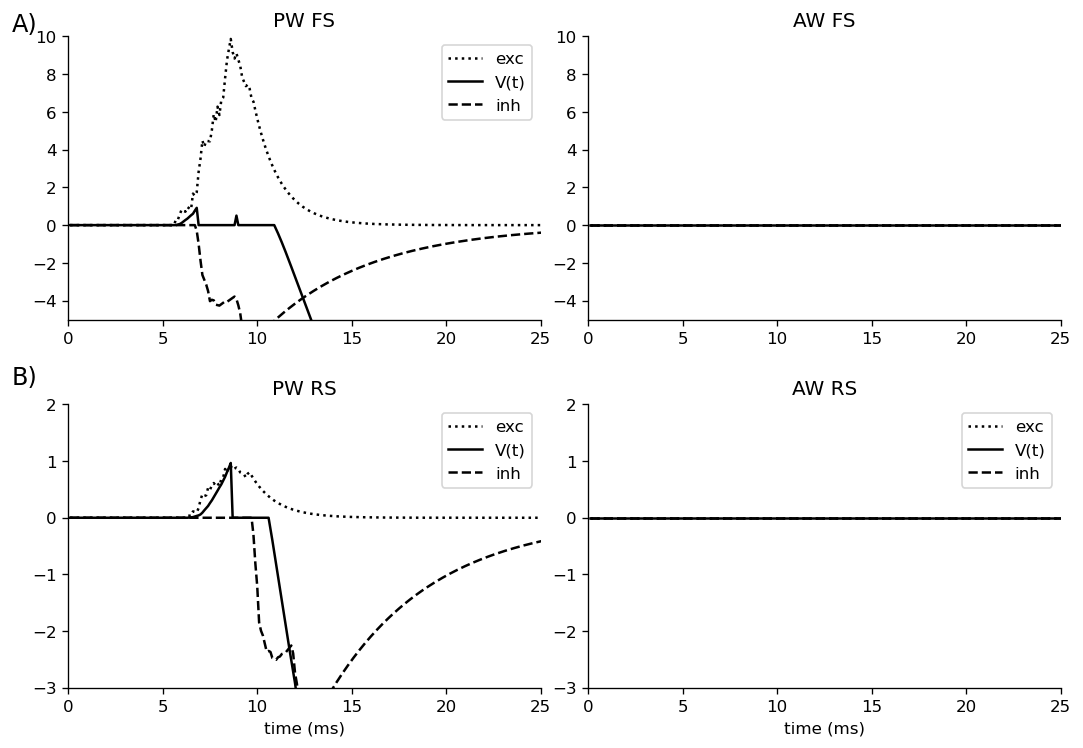

In [9]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,2,dpi=120,figsize=(9,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.1)
x2 = time[0:ASIZE-1]

# plot RS cell

y11 = tcrsexc[PLOTRS-1,:ASIZE-1]
axs[1,0].plot(x2, y11, label = 'exc', color='black',linestyle='dotted')

y12 = rsvolt[PLOTRS-1,:ASIZE-1]
axs[1,0].plot(x2, y12, label = 'V(t)',color='black',linestyle='solid')

y13 = rsinh[PLOTRS-1,:ASIZE-1]
axs[1,0].plot(x2, -y13, label = 'inh',color='black',linestyle='dashed')

axs[1,0].axis([0,25,-3,2])
axs[1,0].legend()

# plot FS cell

y21 = fsexc[PLOTFS-1,:ASIZE-1]
axs[0,0].plot(x2, y21, label = 'exc',color='black',linestyle='dotted')

y22 = fsvolt[PLOTFS-1,:ASIZE-1]
axs[0,0].plot(x2, y22, label = 'V(t)',color='black',linestyle='solid')

y23 = fsinh[PLOTFS-1,:ASIZE-1]
axs[0,0].plot(x2, -y23, label = 'inh',color='black',linestyle='dashed')

axs[0,0].axis([0,25,-5,10])
axs[0,0].legend()

axs[1,0].set_title('PW RS')
axs[0,0].set_title('PW FS')

# plot RS cell

y11b = rsexcA[PLOTRS-1,:ASIZE-1]
axs[1,1].plot(x2, y11b, label = 'exc', color='black',linestyle='dotted')

y12b = rsvoltA[PLOTRS-1,:ASIZE-1]
axs[1,1].plot(x2, y12b, label = 'V(t)',color='black',linestyle='solid')

y13b = rsinhA[PLOTRS-1,:ASIZE-1]
axs[1,1].plot(x2, -y13b, label = 'inh',color='black',linestyle='dashed')

axs[1,1].axis([0,25,-3,2])
axs[1,1].legend()

# plot FS cell

y21b = fsexcA[PLOTFS-1,:ASIZE-1]
axs[0,1].plot(x2, y21b, label = 'exc',color='black',linestyle='dotted')

y22b = fsvoltA[PLOTFS-1,:ASIZE-1]
axs[0,1].plot(x2, y22b, label = 'V(t)',color='black',linestyle='solid')

y23b = fsinhA[PLOTFS-1,:ASIZE-1]
axs[0,1].plot(x2, -y23b, label = 'inh',color='black',linestyle='dashed')

axs[0,1].axis([0,25,-5,10])

plt.setp(axs[1:2], xlabel='time (ms)')

# plt.setp(axs[:], ylabel='')
axs[1,1].set_title('AW RS')
axs[0,1].set_title('AW FS')

fig.text(0,1, 'A)', ha='left', va='top',fontsize='x-large')
# fig.text(0,0.68, 'B)', ha='left', va='top',fontsize='x-large')
fig.text(0,0.51, 'B)', ha='left', va='top',fontsize='x-large')

axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
plt.show()

fig.savefig('figureS2.pdf', format='pdf', dpi=1200,bbox_inches = "tight")

In [87]:
print(rsspmean)
# AWfirst = rsspmean[::20]

print()
print(PWalone)
print(PWfirst)
print(AWfirst)
print()
print(AWalone)

[0.35 0.34 0.18 0.21 0.27 0.37 0.18 0.16 0.15 0.41 0.35 0.2  0.2  0.1
 0.16 0.15 0.3  0.18 0.21 0.17 0.13 0.29 0.43 0.39 0.14 0.19 0.03 0.67
 0.43 0.11 0.09 0.32 0.29 0.37 0.04 0.3  0.16 0.06 0.41 0.23 0.13 0.27
 0.65 0.23 0.39 0.17 0.17 0.05 0.19 0.41 0.58 0.21 0.14 0.28 0.15 0.09
 0.19 0.25 0.1  0.28 0.09 0.41 0.27 0.18 0.11 0.05 0.03 0.42 0.09 0.19
 0.31 0.   0.36 0.15 0.21 0.19 0.16 0.17 0.51 0.14 0.09 0.2  0.68 0.06
 0.13 0.05 0.06 0.14 0.25 0.11 0.13 0.14 0.03 0.   0.24 0.25 0.49 0.21
 0.16 0.16 0.22 0.13 0.23 0.14 0.4  0.22 0.2  0.4  0.48 0.39 0.27 0.04
 0.13 0.16 0.48 0.2  0.42 0.36 0.27 0.26 0.33 0.4  0.08 0.5  0.29 0.35
 0.22 0.33 0.37 0.3  0.23 0.08 0.18 0.15 0.17 0.18 0.2  0.08 0.21 0.08
 0.55 0.07 0.39 0.07 0.15 0.19 0.39 0.21 0.48 0.11 0.31 0.34 0.47 0.33
 0.21 0.14 0.12 0.48 0.36 0.25]

[0.83 1.   0.99 1.   0.96 0.78 0.   0.26]
[0.78 0.99 0.99 1.   0.97 0.59 0.01 0.29]
[0.35 0.13 0.13 0.09 0.09 0.22 0.33 0.55]

[0.36 0.14 0.14 0.06 0.06 0.3  0.38 0.56]


<ipython-input-105-55089334d92c>:2: RuntimeWarning: divide by zero encountered in double_scalars
  inh1 = [x / y for x,y in zip(diff1,PWalone)]
<ipython-input-105-55089334d92c>:7: RuntimeWarning: divide by zero encountered in double_scalars
  inh2 = [x / y for x,y in zip(diff2,PWalone)]


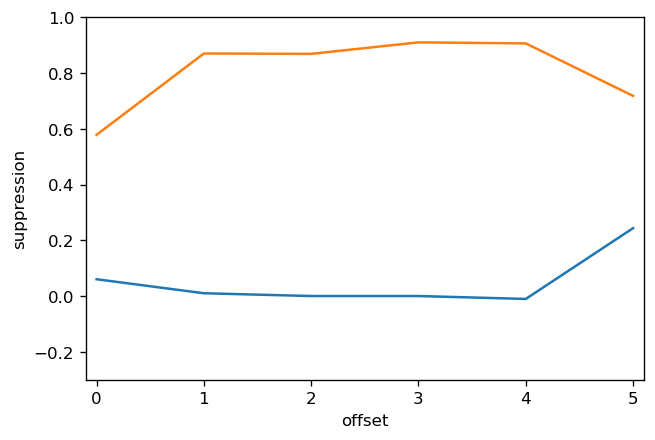

In [105]:
diff1 = [a - b for a, b in zip(PWalone,PWfirst)]
inh1 = [x / y for x,y in zip(diff1,PWalone)]

# print(inh1)

diff2 = [a - b for a, b in zip(PWalone,AWfirst)]
inh2 = [x / y for x,y in zip(diff2,PWalone)]

# print('\n',inh2)

import matplotlib.pyplot as plt
plt.figure(dpi=120)
x = list(range(0, 8))
plt.ylim(-0.3,1)
plt.xlim(-0.1,5.1)
plt.xlabel('offset')
plt.ylabel('suppression')
plt.plot(x,inh1)
plt.plot(x,inh2)

plt.show()

In [9]:
# arrays for mean/sd in number of spikes & latency/jitter to 1st spike (over trials)
fsspmeanA  = np.zeros((numFS,),dtype=float)
fsspikesdA = np.zeros((numFS,),dtype=float)
fslatmeanA = np.zeros((numFS,),dtype=float)
fsjitterA  = np.zeros((numFS,),dtype=float)

rsspmeanA  = np.zeros((tRS,),dtype=float)
rsspikesdA = np.zeros((tRS,),dtype=float)
rslatmeanA = np.zeros((tRS,),dtype=float)
rsjitterA  = np.zeros((tRS,),dtype=float)  

cpmA,cpsA = [0,0],[0,0]
tpmA,tpsA = [0,0],[0,0]
rpmA,rpsA = [0,0],[0,0]
epmA,epsA = [0,0],[0,0]
ipmA,ipsA = [0,0],[0,0]
spmA,spsA = [0,0],[0,0]
fpmA,fpsA = [0,0],[0,0]

# find avg cortical response / all trials
# cortaveA=0.0
# for i in range(1,tRS+1): 
#     cortaveA += rsspmeanA[i-1]
# cortaveA /= tRS

# avg spikes
for i in range(1,numFS+1):                             # avg spikes/trial
    fsspmeanA[i-1] = 0
    for k in range(1,trials+1): 
        fsspmeanA[i-1] += fsspikecountA[k-1,i-1]
    fsspmeanA[i-1] /= trials
for i in range(1,tRS+1): 
    rsspmeanA[i-1] = 0
    for k in range(1,trials+1): 
        rsspmeanA[i-1] += rsspikecountA[k-1,i-1]
    rsspmeanA[i-1] /= trials

# stdev of spikes
for i in range(1,numFS+1): 
    fsspikesdA[i-1]=0.0
    for k in range(1,trials+1): 
        fsspikesdA[i-1] += ((fsspikecountA[k-1,i-1] - fsspmeanA[i-1]) * 
        (fsspikecountA[k-1,i-1] - fsspmeanA[i-1]))
    fsspikesdA[i-1] = math.sqrt(fsspikesdA[i-1]/trials)
for i in range(1,tRS+1): 
    rsspikesdA[i-1]=0.0;
    for k in range(1,trials+1): 
        rsspikesdA[i-1] += ((rsspikecountA[k-1,i-1] - rsspmeanA[i-1]) * 
        (rsspikecountA[k-1,i-1] - rsspmeanA[i-1]))
    rsspikesdA[i-1] = math.sqrt(rsspikesdA[i-1]/trials)

# avg latency of first spike
for i in range(1,numFS+1): 
    fslatmeanA[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if (fsspikecountA[k-1,i-1] > 0) and (fsspiketimesA[k-1,i-1,0]): 
            temp += 1
            fslatmeanA[i-1] += fsspiketimesA[k-1,i-1,0]
    if temp>0: 
        fslatmeanA[i-1] /= temp
for i in range(1,tRS+1): 
    rslatmeanA[i-1]=0.0; temp=0
    temp = 0
    for k in range(1,trials+1): 
        if (rsspikecountA[k-1,i-1] > 0) and (rsspiketimesA[k-1,i-1,0] >= 0): 
            temp += 1
            rslatmeanA[i-1] += rsspiketimesA[k-1,i-1,0]
    if temp>0: 
        rslatmeanA[i-1] /= temp

# jitter (stdev over mean spike time)
for i in range(1,numFS+1): 
    fsjitterA[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if fsspikecountA[k-1,i-1] > 0: 
            temp += 1
            fsjitterA[i-1] += (fsspiketimesA[k-1,i-1,0] - fslatmeanA[i-1]) ** 2
    if temp>0: 
        fsjitterA[i-1] = math.sqrt(fsjitterA[i-1]/temp)
for i in range(1,tRS+1): 
    rsjitterA[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if rsspikecountA[k-1,i-1] > 0: 
            temp += 1
            rsjitterA[i-1] += (rsspiketimesA[k-1,i-1,0] - rslatmeanA[i-1]) ** 2
    if temp>0: 
        rsjitterA[i-1] = math.sqrt(rsjitterA[i-1]/temp)
        
# avg and stdev for peak times
for i in range(1,trials+1): 
    tpmA = [(tpmA[x] + tpeakA[i-1,x]) for x in range(2)]
    rpmA = [(rpmA[x] + rpeakA[i-1,x]) for x in range(2)]
    epmA = [(epmA[x] + epeakA[i-1,x]) for x in range(2)]
    ipmA = [(ipmA[x] + ipeakA[i-1,x]) for x in range(2)]
    spmA = [(spmA[x] + speakA[i-1,x]) for x in range(2)]
    cpmA = [(cpmA[x] + repeakA[i-1,x]) for x in range(2)]
    fpmA = [(fpmA[x] + fsepeakA[i-1,x]) for x in range(2)]
tpmA = [x / trials for x in tpmA]
rpmA = [x / trials for x in rpmA]
epmA = [x / trials for x in epmA]
ipmA = [x / trials for x in ipmA]
spmA = [x / trials for x in spmA]
cpmA = [x / trials for x in cpmA]
fpmA = [x / trials for x in fpmA]

# avg and stdev for peak amplitudes
for i in range(1,trials+1): 
    tpsA[0]+=(tpeakA[i-1,0]-tpmA[0])*(tpeakA[i-1,0]-tpmA[0])
    tpsA[1]=(tpeakA[i-1,1]-tpmA[1])*(tpeakA[i-1,1]-tpmA[1])
    rpsA[0]+=(rpeakA[i-1][0]-rpmA[0])*(rpeakA[i-1][0]-rpmA[0])
    rpsA[1]=(rpeakA[i-1][1]-rpmA[1])*(rpeakA[i-1][1]-rpmA[1])
    epsA[0]+=(epeakA[i-1][0]-epmA[0])*(epeakA[i-1][0]-epmA[0])
    epsA[1]=(epeakA[i-1][1]-epmA[1])*(epeakA[i-1][1]-epmA[1])
    ipsA[0]+=(ipeakA[i-1][0]-ipmA[0])*(ipeakA[i-1][0]-ipmA[0])
    ipsA[1]=(ipeakA[i-1][1]-ipmA[1])*(ipeakA[i-1][1]-ipmA[1])
    spsA[0]+=(speakA[i-1][0]-spmA[0])*(speakA[i-1][0]-spmA[0])
    spsA[1]=(speakA[i-1][1]-spmA[1])*(speakA[i-1][1]-spmA[1])
    cpsA[0]+=(repeakA[i-1,0]-cpmA[0])*(repeakA[i-1,0]-cpmA[0])
    cpsA[1]=(repeakA[i-1,1]-cpmA[1])*(repeakA[i-1,1]-cpmA[1])
    fpsA[0]+=(fsepeakA[i-1,0]-fpmA[0])*(fsepeakA[i-1,0]-fpmA[0])
    fpsA[1]=(fsepeakA[i-1,1]-fpmA[1])*(fsepeakA[i-1,1]-fpmA[1])
tpsA = [math.sqrt(x/trials) for x in tpsA]
rpsA = [math.sqrt(x/trials) for x in rpsA]
epsA = [math.sqrt(x/trials) for x in epsA]
ipsA = [math.sqrt(x/trials) for x in ipsA]
spsA = [math.sqrt(x/trials) for x in spsA]
cpsA = [math.sqrt(x/trials) for x in cpsA]
fpsA = [math.sqrt(x/trials) for x in fpsA]

temp1 = 0 # mean time difference in exc and inh peaks
for i in range(1,trials+1):
    temp1 += ipeakA[i-1,0]-epeak[i-1,0] # for i in range(1,trials+1)
temp1 /= trials

temp2 = 0 # stdev of temp1
for i in range(1,trials+1):
    temp2 += (ipeak[i-1,0]-epeak[i-1,0]-temp1)*(ipeak[i-1,0]-epeak[i-1,0]-temp1)
temp2 = math.sqrt(temp2/trials)

temp3 = 0 # fepeak
for i in range(1,trials+1):
    temp3 += fepeak[i-1,1]
    temp3 /= trials

temp4 = 0 # stdev of temp3
for i in range(1,trials+1):
    temp4 += (fepeak[i-1,1]-temp3)*(fepeak[i-1,1]-temp3)
temp4 = math.sqrt(temp4/trials)

tpm,tps = [0,0],[0,0]
rpm,rps = [0,0],[0,0]
epm,eps = [0,0],[0,0]
ipm,ips = [0,0],[0,0]
spm,sps = [0,0],[0,0]
fpm,fps = [0,0],[0,0]

# mean/sd in number of spikes & latency to 1st spike (over trials)
fsspmean  = np.zeros((numFS,),dtype=float)
fsspikesd = np.zeros((numFS,),dtype=float)
fslatmean = np.zeros((numFS,),dtype=float)
fsjitter  = np.zeros((numFS,),dtype=float)

rsspmean  = np.zeros((tRS,),dtype=float)
rsspikesd = np.zeros((tRS,),dtype=float)
rslatmean = np.zeros((tRS,),dtype=float)
rsjitter  = np.zeros((tRS,),dtype=float)  

# find averages, stdevs, etc
for i in range(1,numFS+1):                             # avg spikes/trial
    fsspmean[i-1] = 0
    for k in range(1,trials+1): 
        fsspmean[i-1] += fsspikecount[k-1,i-1]
    fsspmean[i-1] /= trials
for i in range(1,tRS+1): 
    rsspmean[i-1] = 0
    for k in range(1,trials+1): 
        rsspmean[i-1] += rsspikecount[k-1,i-1]
    rsspmean[i-1] /= trials

# find avg cortical response / all trials
cortave=0.0
for i in range(1,tRS+1): 
    cortave += rsspmean[i-1]
cortave /= tRS

# find avg group response / all trials
gave=0.0
for i in range((groupav-1)*numRS + 1,groupav*numRS): 
    gave += rsspmean[i-1]
gave /= numRS

# stdev of spike times
for i in range(1,numFS+1): 
    fsspikesd[i-1]=0.0
    for k in range(1,trials+1): 
        fsspikesd[i-1] += ((fsspikecount[k-1,i-1] - fsspmean[i-1]) * 
        (fsspikecount[k-1,i-1] - fsspmean[i-1]))
    fsspikesd[i-1] = math.sqrt(fsspikesd[i-1]/trials)
for i in range(1,tRS+1): 
    rsspikesd[i-1]=0.0;
    for k in range(1,trials+1): 
        rsspikesd[i-1] += ((rsspikecount[k-1,i-1] - rsspmean[i-1]) * 
        (rsspikecount[k-1,i-1] - rsspmean[i-1]))
    rsspikesd[i-1] = math.sqrt(rsspikesd[i-1]/trials)

# avg latency of first spike
for i in range(1,numFS+1): 
    fslatmean[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if (fsspikecount[k-1,i-1] > 0) and (fsspiketimes[k-1,i-1,0]): 
            temp += 1
            fslatmean[i-1] += fsspiketimes[k-1,i-1,0]
    if temp>0: 
        fslatmean[i-1] /= temp
for i in range(1,tRS+1): 
    rslatmean[i-1]=0.0; temp=0
    temp = 0
    for k in range(1,trials+1): 
        if (rsspikecount[k-1,i-1] > 0) and (rsspiketimes[k-1,i-1,0] >= 0): 
            temp += 1
            rslatmean[i-1] += rsspiketimes[k-1,i-1,0]
    if temp>0: 
        rslatmean[i-1] /= temp

# jitter (stdev over mean spike time)
for i in range(1,numFS+1): 
    fsjitter[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if fsspikecount[k-1,i-1] > 0: 
            temp += 1
            fsjitter[i-1] += (fsspiketimes[k-1,i-1,0] - fslatmean[i-1]) ** 2
    if temp>0: 
        fsjitter[i-1] = math.sqrt(fsjitter[i-1]/temp)
for i in range(1,tRS+1): 
    rsjitter[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if rsspikecount[k-1,i-1] > 0: 
            temp += 1
            rsjitter[i-1] += (rsspiketimes[k-1,i-1,0] - rslatmean[i-1]) ** 2
    if temp>0: 
        rsjitter[i-1] = math.sqrt(rsjitter[i-1]/temp)
        
# avg and stdev for peak times
for i in range(1,trials+1): 
    tpm = [(tpm[x] + tpeak[i-1,x]) for x in range(2)]
    rpm = [(rpm[x] + rpeak[i-1,x]) for x in range(2)]
    epm = [(epm[x] + epeak[i-1,x]) for x in range(2)]
    ipm = [(ipm[x] + ipeak[i-1,x]) for x in range(2)]
    spm = [(spm[x] + speak[i-1,x]) for x in range(2)]
    fpm = [(fpm[x] + fsepeak[i-1,x]) for x in range(2)]
tpm = [x / trials for x in tpm]
rpm = [x / trials for x in rpm]
epm = [x / trials for x in epm]
ipm = [x / trials for x in ipm]
spm = [x / trials for x in spm]
fpm = [x / trials for x in fpm]

# avg and stdev for peak amplitudes
for i in range(1,trials+1): 
    tps[0]+=(tpeak[i-1,0]-tpm[0])*(tpeak[i-1,0]-tpm[0])
    tps[1]=(tpeak[i-1,1]-tpm[1])*(tpeak[i-1,1]-tpm[1])
    rps[0]+=(rpeak[i-1][0]-rpm[0])*(rpeak[i-1][0]-rpm[0])
    rps[1]=(rpeak[i-1][1]-rpm[1])*(rpeak[i-1][1]-rpm[1])
    eps[0]+=(epeak[i-1][0]-epm[0])*(epeak[i-1][0]-epm[0])
    eps[1]=(epeak[i-1][1]-epm[1])*(epeak[i-1][1]-epm[1])
    ips[0]+=(ipeak[i-1][0]-ipm[0])*(ipeak[i-1][0]-ipm[0])
    ips[1]=(ipeak[i-1][1]-ipm[1])*(ipeak[i-1][1]-ipm[1])
    sps[0]+=(speak[i-1][0]-spm[0])*(speak[i-1][0]-spm[0])
    sps[1]=(speak[i-1][1]-spm[1])*(speak[i-1][1]-spm[1])
    fps[0]+=(fsepeak[i-1][0]-fpm[0])*(fsepeak[i-1][0]-fpm[0])
    fps[1]=(fsepeak[i-1][1]-fpm[1])*(fsepeak[i-1][1]-fpm[1])
tps = [math.sqrt(x/trials) for x in tps]
rps = [math.sqrt(x/trials) for x in rps]
eps = [math.sqrt(x/trials) for x in eps]
ips = [math.sqrt(x/trials) for x in ips]
sps = [math.sqrt(x/trials) for x in sps]
fps = [math.sqrt(x/trials) for x in fps]

temp1 = 0 # mean time difference in exc and inh peaks
for i in range(1,trials+1):
    temp1 += ipeak[i-1,0]-epeak[i-1,0] # for i in range(1,trials+1)
temp1 /= trials

temp2 = 0 # stdev of temp1
for i in range(1,trials+1):
    temp2 += (ipeak[i-1,0]-epeak[i-1,0]-temp1)*(ipeak[i-1,0]-epeak[i-1,0]-temp1)
temp2 = math.sqrt(temp2/trials)

temp3 = 0 # fepeak
for i in range(1,trials+1):
    temp3 += fepeak[i-1,1]
    temp3 /= trials

temp4 = 0 # stdev of temp3
for i in range(1,trials+1):
    temp4 += (fepeak[i-1,1]-temp3)*(fepeak[i-1,1]-temp3)
temp4 = math.sqrt(temp4/trials)

cortaveA = 0.0
for i in range(1,tRS+1): 
    cortaveA+=rsspmeanA[i-1]
cortaveA /= tRS

# print('simulated velocity is',1/TCsd,'on direction group',(defdir-1)*45)
# print('\n')

# print('average cortical response:',cortave)
# print('average group',groupav,'response:',gave)
# print('\n')

# print('RS cell',PLOTRS,'had a peak in fe (e/(e+i)) of amplitude',temp3,'with standard deviation',temp4)
# print('RS cell',PLOTRS,'had a mean time difference in exc and inh peaks of',temp1,'ms with std dev',temp2)



print('simulated velocity is',1/TCsd,'on direction group',(defdir-1)*45)
print('\n')

print('FS cell #',PLOTFS,'PW deflection results:',
      '\n avg # spikes',fsspmean[PLOTFS-1],'w/ stdev',fsspikesd[PLOTFS-1],
      '\n avg latency:',fslatmean[PLOTFS-1],'ms w/ jitter',fsjitter[PLOTFS-1],'ms')
print('\n')
print('FS cell #',PLOTFSA,'AW deflection results:',
      '\n avg # spikes',fsspmeanA[PLOTFSA-1],'w/ stdev',fsspikesdA[PLOTFSA-1],
      '\n avg latency:',fslatmeanA[PLOTFSA-1],'ms w/ jitter',fsjitterA[PLOTFSA-1],'ms')
print('\n')

print('RS cell #:',PLOTRS,'in group',int((PLOTRS/numRS)+1),'PW results:'
      '\n avg # spikes',rsspmean[PLOTRS-1],'w/ stdev',rsspikesd[PLOTRS-1],
      '\n avg latency',rslatmean[PLOTRS-1],'ms w/ jitter',rsjitter[PLOTRS-1],'ms')
print('\n')
print('RS cell #:',PLOTRSA,'AW results:'
      '\n avg # spikes',rsspmeanA[PLOTRSA-1],'w/ stdev',rsspikesdA[PLOTRSA-1],
      '\n avg latency',rslatmeanA[PLOTRSA-1],'ms w/ jitter',rsjitterA[PLOTRSA-1],'ms')
print('\n')

print('RS cell #',PLOTRS,'PW deflection peak times for\n',
      'tc input',tpm[0],'with stdev',tps[0],
      '\n rs input',rpm[0],'with stdev',rps[0],
      '\n exc input',epm[0],'with stdev',eps[0],
      '\n inh input',ipm[0],'with stdev',ips[0],
      '\n syn input',spm[0],'with stdev',sps[0])
print('\n')

print('RS cell #',PLOTRSA,'AW deflection peak times for\n',
      'cross input',tpmA[0],'with stdev',tpsA[0],
      '\n rs input',rpmA[0],'with stdev',rpsA[0],
      '\n exc input',epmA[0],'with stdev',epsA[0],
      '\n inh input',ipmA[0],'with stdev',ipsA[0],
      '\n syn input',spmA[0],'with stdev',spsA[0])
print('\n')

print('RS cell #',PLOTRS,'PW deflection peak amplitude for\n',
      'tc input',tpm[1],'with stdev',tps[1],
      '\n rs input',rpm[1],'with stdev',rps[1],
      '\n exc input',epm[1],'with stdev',eps[1],
      '\n inh input',ipm[1],'with stdev',ips[1],
      '\n syn input',spm[1],'with stdev',sps[1])
print('\n')

print('RS cell #',PLOTRSA,'AW deflection peak amplitude for\n',
      'cross input',cpmA[1],'with stdev',cpsA[1],
      '\n tc input',tpmA[1],'with stdev',tpsA[1],
      '\n rs input',rpmA[1],'with stdev',rpsA[1],
      '\n exc input',epmA[1],'with stdev',epsA[1],
      '\n inh input',ipmA[1],'with stdev',ipsA[1],
      '\n syn input',spmA[1],'with stdev',spsA[1])
print('\n')

# print('AW exc is',(epmA[1]/epm[1])*100,'% str of PW exc input')
# print('\ncross input yields',(sum(spikecountA)/(tRS*trials))/(sum(spikecount)/(tRS*trials))*100,
#       '% of response to PW deflection')
# print('\ncross input yields',(rsspmeanA[PLOTRSA-1]/rsspmean[PLOTRS-1])*100,'% of response to PW deflection')

# # average response by group / all trials
# groups=[]
# for i in range(1,numdir+1):
#     gave=0.0
#     for k in range((i-1)*numRS + 1,i*numRS+1): 
#         gave += rsspmeanA[k-1]
#     gave /= numRS
#     print('\ngroup',i,'average resp:',gave)
# print('\n')

# print("\n")
# print("Average number of RS spikes per trial (each row is a group):\n")
# for i in range(1,tRS+1): 
#     print(i,rsspmeanA[i-1])
#     if (i%numRS==0):
#         print("\n")

# print('RS cell',PLOTRS,'had a peak in fe (e/(e+i)) of amplitude',temp3,'with standard deviation',temp4)
# print('RS cell',PLOTRS,'had a mean time difference in exc and inh peaks of',temp1,'ms with std dev',temp2)

# print(rsspmeanA)

simulated velocity is 1.0 on direction group 90


FS cell # 4 PW deflection results: 
 avg # spikes 0.73 w/ stdev 0.4439594576084626 
 avg latency: 11.697260273972601 ms w/ jitter 0.23289282780661283 ms


FS cell # 24 AW deflection results: 
 avg # spikes 1.82 w/ stdev 0.38418745424597056 
 avg latency: 7.219000000000002 ms w/ jitter 0.32301547950523973 ms


RS cell #: 54 in group 3 PW results:
 avg # spikes 0.17 w/ stdev 0.37563279941985916 
 avg latency 14.02352941176471 ms w/ jitter 0.2262986360196628 ms


RS cell #: 22 AW results:
 avg # spikes 1.0 w/ stdev 0.0 
 avg latency 8.771 ms w/ jitter 0.1935432768142567 ms


RS cell # 54 PW deflection peak times for
 tc input 0.0 with stdev 0.0 
 rs input 0.0 with stdev 0.0 
 exc input 0.0 with stdev 0.0 
 inh input 14.904000000000003 with stdev 0.20828826179120136 
 syn input 0.0 with stdev 0.0


RS cell # 22 AW deflection peak times for
 cross input 8.596000000000005 with stdev 0.35690895197514977 
 rs input 0.0 with stdev 0.0 
 exc inpu

In [144]:
import statistics as st
print(st.stdev(Rspike))
print(st.stdev(RspikeA))
print(st.stdev(Fspike))
print(st.stdev(FspikeA))

print(RspikeA)

0.014757467070432627
0.0850052567616297
0.14470144636283055
0.03607782501363379
[0.85625, 0.64375, 0.6604166666666667, 0.5265625, 0.425, 0.403125, 0.35, 0.375, 0.43680555555555556, 0.406875, 0.3704545454545455, 0.403125, 0.38846153846153847, 0.40133928571428573, 0.3754166666666667, 0.398828125, 0.4235294117647059, 0.40069444444444446, 0.38552631578947366, 0.3821875, 0.3854166666666667, 0.37272727272727274, 0.3948369565217391, 0.41432291666666665, 0.405, 0.41418269230769234, 0.42824074074074076, 0.43705357142857143, 0.4504310344827586, 0.4658333333333333, 0.45806451612903226, 0.4703125, 0.4856060606060606, 0.49503676470588237, 0.4835714285714286, 0.4703125, 0.4652027027027027, 0.4764802631578947, 0.46458333333333335, 0.4753125, 0.4850609756097561, 0.475297619047619, 0.47325581395348837, 0.48522727272727273, 0.49666666666666665, 0.5009510869565217, 0.5105053191489362, 0.5045572916666666, 0.5114795918367347, 0.517125]


In [166]:
print(st.stdev(Rspike))
print(st.stdev(RspikeA))
print(st.stdev(Fspike))
print(st.stdev(FspikeA))

0.014132212755813006
0.036897386163446934
0.009872043864495243
0.015447196278360052


In [198]:
preFS = []
preRS = []
preFSA = []
preRSA = []

np.random.seed(444)

for i in range(1,21):
    i = (np.random.randint(1, 121))
    preRS.append((sum(rsspikecount)[i-1]/trials))
    preRSA.append((sum(rsspikecountA)[i-1]/trials))
    
for i in range(1,21):
    preFS.append((sum(fsspikecount)[i-1]/trials))
    preFSA.append((sum(fsspikecountA)[i-1]/trials))

print(preRS)
print(preFS)
print(preRSA)
print(preFSA)

[0.98, 0.14, 1.0, 0.46, 1.0, 1.0, 0.12, 0.92, 1.0, 0.68, 1.0, 1.0, 0.02, 1.0, 1.0, 1.0, 1.0, 0.5, 0.9, 1.0]
[1.78, 1.38, 1.28, 1.64, 1.52, 1.52, 1.84, 1.62, 1.3, 1.42, 1.8, 1.8, 1.48, 1.3, 1.1, 1.28, 1.74, 1.22, 1.22, 1.8]
[0.22, 0.04, 0.2, 0.06, 0.3, 0.06, 0.04, 0.14, 0.02, 0.02, 0.2, 0.08, 0.42, 0.2, 0.0, 0.08, 0.0, 0.3, 0.38, 0.1]
[0.94, 1.0, 1.0, 0.0, 0.96, 0.12, 0.98, 0.98, 0.0, 0.08, 0.26, 0.72, 0.92, 0.78, 0.48, 0.66, 0.14, 1.0, 0.0, 0.64]


In [203]:
postRS = []
postFS = []
postRSA = []
postFSA = []

for i in range(1,21):
    i = (np.random.randint(1, 121))
    postRS.append((sum(rsspikecount)[i-1]/trials))
    postRSA.append((sum(rsspikecountA)[i-1]/trials))
    
for i in range(1,21):
    postFS.append((sum(fsspikecount)[i-1]/trials))
    postFSA.append((sum(fsspikecountA)[i-1]/trials))
    
print(postRS)
print(postFS)
print(postRSA)
print(postFSA)

[1.0, 1.0, 0.52, 1.0, 0.5, 1.0, 0.88, 1.0, 1.0, 1.0, 0.94, 1.0, 1.0, 1.0, 1.0, 0.22, 0.84, 0.98, 1.0, 0.98]
[1.86, 1.36, 1.28, 1.66, 1.64, 1.46, 1.82, 1.56, 1.32, 1.34, 1.78, 1.68, 1.62, 1.36, 1.14, 1.42, 1.72, 1.16, 1.34, 1.8]
[0.1, 0.0, 0.14, 0.16, 0.12, 0.0, 0.3, 0.12, 0.16, 0.1, 0.1, 0.06, 0.42, 0.1, 0.1, 0.12, 0.06, 0.14, 0.32, 0.04]
[0.96, 1.0, 1.0, 0.0, 1.0, 0.08, 0.98, 1.0, 0.0, 0.1, 0.2, 0.76, 0.96, 0.8, 0.54, 0.62, 0.2, 1.0, 0.0, 0.68]


In [204]:
ls1 = [c/t for c,t in zip(postFS, preFS)]
ls2 = [c/t for c,t in zip(postRS, preRS)]

ls3 = [c/t for c,t in zip(postFSA, preFSA)]
ls4 = [c/t for c,t in zip(postRSA, preRSA)]

print(ls1)
print(ls2)
print(ls3)
print(ls4)

[1.0449438202247192, 0.9855072463768118, 1.0, 1.0121951219512195, 1.0789473684210527, 0.9605263157894737, 0.9891304347826086, 0.9629629629629629, 1.0153846153846153, 0.943661971830986, 0.9888888888888889, 0.9333333333333332, 1.0945945945945947, 1.0461538461538462, 1.0363636363636362, 1.109375, 0.9885057471264368, 0.9508196721311475, 1.098360655737705, 1.0]
[1.0204081632653061, 7.142857142857142, 0.52, 2.1739130434782608, 0.5, 1.0, 7.333333333333334, 1.0869565217391304, 1.0, 1.4705882352941175, 0.94, 1.0, 50.0, 1.0, 1.0, 0.22, 0.84, 1.96, 1.1111111111111112, 0.98]
[1.0212765957446808, 1.0, 1.0, nan, 1.0416666666666667, 0.6666666666666667, 1.0, 1.0204081632653061, nan, 1.25, 0.7692307692307693, 1.0555555555555556, 1.0434782608695652, 1.0256410256410258, 1.1250000000000002, 0.9393939393939393, 1.4285714285714286, 1.0, nan, 1.0625]
[0.4545454545454546, 0.0, 0.7000000000000001, 2.666666666666667, 0.4, 0.0, 7.5, 0.857142857142857, 8.0, 5.0, 0.5, 0.75, 1.0, 0.5, inf, 1.5, inf, 0.4666666666666

<ipython-input-204-a798fb2f8c41>:4: RuntimeWarning: invalid value encountered in double_scalars
  ls3 = [c/t for c,t in zip(postFSA, preFSA)]
<ipython-input-204-a798fb2f8c41>:5: RuntimeWarning: divide by zero encountered in double_scalars
  ls4 = [c/t for c,t in zip(postRSA, preRSA)]


0.402618448588756
0.8658449021020413
0.11706731816902027
0.23146832188944771
12.09
8.83
15.48
15.360000000000003


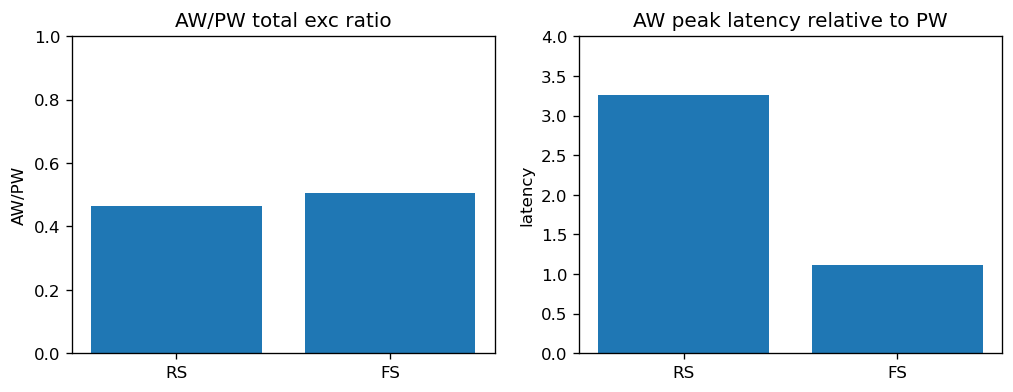

In [69]:
print(epmA[1])
print(epm[1])
print(ipmA[1])
print(ipm[1])
print(epmA[0])
print(epm[0])
print(ipmA[0])
print(ipm[0])

fig, axs = plt.subplots(1,2,dpi=120,figsize = (10,3.5))

# AW/PW ratio of total excitation, AW latency

x = ['RS','FS']
y1 = [epmA[1]/epm[1],ipmA[1]/ipm[1]]
y2 = [epmA[0]-epm[0],ipmA[0]-ipm[0]+1]
axs[0].bar(x,y1)
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,4])
axs[1].bar(x,y2)
axs[0].set_title('AW/PW total exc ratio')
axs[1].set_title('AW peak latency relative to PW')

plt.setp(axs[0], xlabel='')
plt.setp(axs[1], xlabel='')
plt.setp(axs[0], ylabel='AW/PW')
plt.setp(axs[1], ylabel='latency')

plt.show()


In [52]:
spikecountA = sum(rsspikecountA)
print(sum(spikecountA)/(tRS*trials))

# print(sum(rsspikecount))
spikecount = sum(rsspikecount)
print(sum(spikecount)/(tRS*trials))

# print(sum(fsspikecountA))
fsspikeA = sum(fsspikecountA)
print(sum(fsspikeA)/(numFS*trials))

# print(sum(fsspikecount))
fsspike = sum(fsspikecount)
print(sum(fsspike)/(numFS*trials))

print(100*np.count_nonzero(spikecountA)/len(spikecountA))

0.7325
0.796875
1.377
4.187
100.0


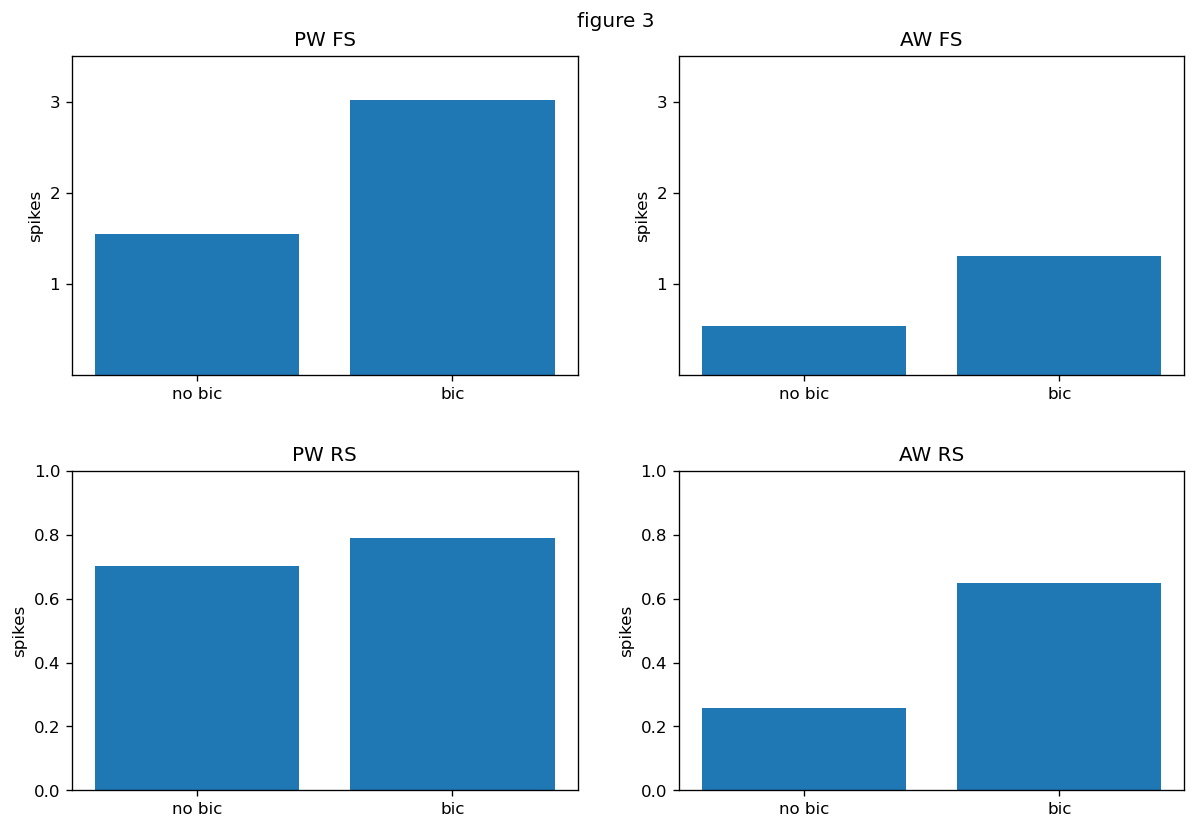

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2,dpi=120,figsize = (10,7))

x = ['no bic','bic']
fig.suptitle('figure 3')
fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.2)

y1 = [0.2575,0.648125]
y2 = [0.70375,0.791875]
y3 = [0.535,1.306]
y4 = [1.551,3.0216]



# y1 = [0,sum(spikecountA)/(tRS*trials)]
# y2 = [0,sum(spikecount)/(tRS*trials)]
# y3 = [0,sum(fsspikeA)/(numFS*trials)]
# y4 = [0,sum(fsspike)/(numFS*trials)]


ax[1,1].bar(x,y1)
ax[1,0].bar(x,y2)
ax[0,1].bar(x,y3)
ax[0,0].bar(x,y4)

ax[1,1].set_ylim([0,1])
ax[1,0].set_ylim([0,1])
ax[0,1].set_ylim([0,3.5])
ax[0,0].set_ylim([0,3.5])

# ax[0,:].set_title('PW')
# ax[1,:].set_title('AW')


ax[1,1].set_title('AW RS')
ax[1,0].set_title('PW RS')
ax[0,1].set_title('AW FS')
ax[0,0].set_title('PW FS')

plt.setp(ax[:], ylabel='spikes')


ax[0,1].set_yticks([1,2,3])
ax[0,0].set_yticks([1,2,3])

plt.show()